In [4]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
import requests
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
df = pd.read_csv(path + './fires_in_ph_clean.csv')

<ipython-input-5-fe2d558c2bc7>:1: DtypeWarning: Columns (69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + './fires_in_ph_clean.csv')


In [6]:
df = df.fillna(df.mean())
df = df.dropna(axis=1, how='all')

<ipython-input-6-6470a4fef115>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


In [7]:
df = df.drop(columns=['cbsa_nm', 'urb_out'], axis=1)

In [8]:
target_cols = ['building_fires_11_19', 'building_fires_20_21']

# Make the targets into a binary classification problem
for col in target_cols:
  df[col] = df[col] > 0

In [9]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=target_cols, axis=1)
y = df['building_fires_11_19']

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=538)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# param_dist = {
#     'n_estimators': [10, 50, 100, 200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [None] + list(np.arange(3, 20)),
#     'min_samples_split': np.arange(2, 11),
#     'min_samples_leaf': np.arange(1, 11),
#     'bootstrap': [True, False],
#     'criterion': ['gini', 'entropy']
# }

# rf = RandomForestClassifier(random_state=538)

# random_search = RandomizedSearchCV(
#     rf,
#     param_distributions=param_dist,
#     n_iter=20,
#     scoring='recall',
#     cv=5,
#     n_jobs=-1,
#     random_state=42,
#     verbose=2
# )

# random_search.fit(X_train_resampled, y_train_resampled)

# rf = random_search.best_estimator_

rf = RandomForestClassifier(
    random_state=538, n_estimators=500, min_samples_split= 5,
    min_samples_leaf= 1, max_features= 'sqrt', max_depth= 16,
    criterion= 'gini', bootstrap= False
)
rf.fit(X_train_resampled, y_train_resampled);

In [11]:
# print(random_search.best_params_)

In [12]:
y_pred = rf.predict(X_test_scaled)

In [13]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.99      0.96      0.98     37927
        True       0.11      0.43      0.18       450

    accuracy                           0.95     38377
   macro avg       0.55      0.70      0.58     38377
weighted avg       0.98      0.95      0.97     38377



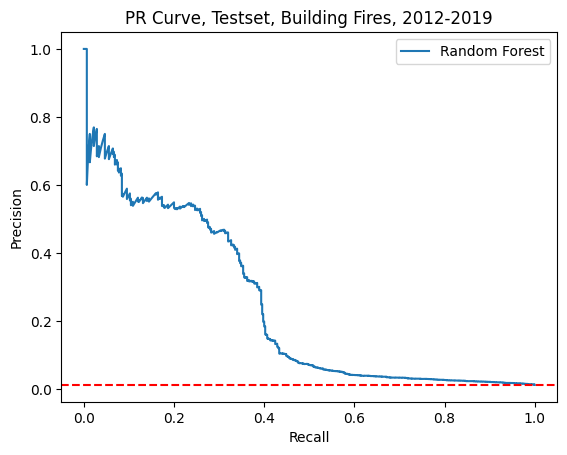

In [14]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = rf.predict_proba(X_test_scaled)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve, Testset, Building Fires, 2012-2019")
plt.axhline(df.building_fires_11_19.sum() / len(df), color='r', linestyle='--')
plt.legend()
plt.show()


array([[<Axes: title={'center': '0'}>]], dtype=object)

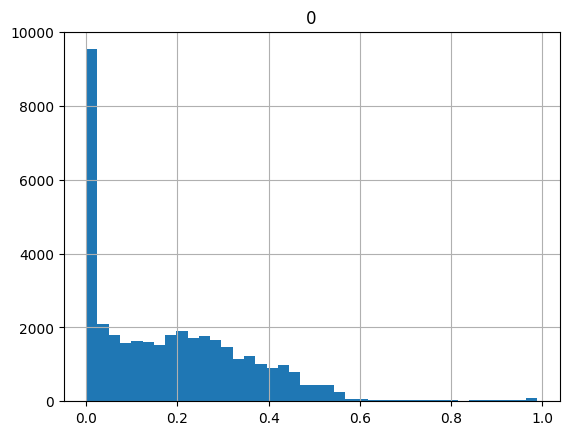

In [15]:
probabilities = rf.predict_proba(X_test_scaled)[:,1]
pd.DataFrame(probabilities).hist(bins=40)


In [16]:
feature_names = X_train.columns

importances = rf.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")


total_dwelling_units: 0.05865834221234315
msa_nm: 0.052763026031648765
total_units: 0.05028852439799472
msgusps: 0.05008783162436395
acc_units: 0.04717190264443968
total_occupied: 0.046569051826905135
number_reported: 0.03784560280966976
std_zip5: 0.03417554587037861
pha_total_units: 0.032906863427056406
building_type_code_RW: 0.02359125205988462
building_type_code_SD: 0.02283139146467671
regular_vacant: 0.021916947221701715
building_type_code_ES: 0.0211421394691205
lvl2kx_R: 0.021074478797531125
metro: 0.020932346799340782
msg2kx_** Street-Level Rooftop **: 0.01923494904689863
addr_type_H: 0.016131672138880743
msg2kx_**  Centroid Lat/Long   **: 0.015969393262614182
apt_type_MISSING_VALUE: 0.01566617956921514
addr_type_S: 0.015568638033831217
apt_type_Apt: 0.015340719830494046
dofa_actual_year: 0.014896721536905808
pct_occupied: 0.014444529504136414
pct_lt5k: 0.01414529964072823
construction_year: 0.01330874603614735
pct_overhoused: 0.013208085789555783
months_from_movein: 0.0131631067

In [17]:
X_val = df.drop(columns=target_cols, axis=1)
y_val = df['building_fires_20_21']

scaler = StandardScaler()

X_val_scaled = scaler.fit_transform(X_val)

y_pred_val = rf.predict(X_val_scaled)


              precision    recall  f1-score   support

       False       1.00      0.34      0.51    190855
        True       0.01      0.91      0.01      1030

    accuracy                           0.34    191885
   macro avg       0.50      0.63      0.26    191885
weighted avg       0.99      0.34      0.50    191885



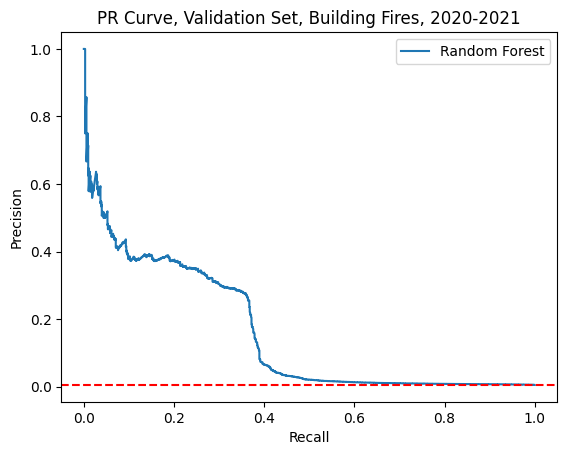

In [18]:
report = classification_report(y_val, y_pred_val)
print(report)

y_scores = rf.predict_proba(X_val_scaled)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

plt.plot(recall, precision, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve, Validation Set, Building Fires, 2020-2021")
plt.axhline(df['building_fires_20_21'].sum() / len(df), color='r', linestyle='--')
plt.legend()
plt.show()

array([[<Axes: title={'center': '0'}>]], dtype=object)

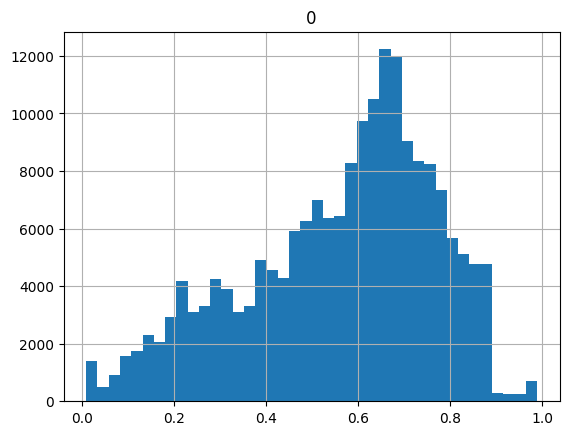

In [19]:
probabilities = rf.predict_proba(X_val_scaled)[:,1]
pd.DataFrame(probabilities).hist(bins=40)


In [25]:
from google.colab import files

probabilities = rf.predict_proba(X_val_scaled)
fire_probabilities = probabilities[:, 1]

df2 = pd.read_csv(path + './fires_in_ph_clean.csv')
df2 = df2.fillna(df2.mean())
df2 = df2.dropna(axis=1, how='all')
df2 = df2.drop(columns=['cbsa_nm', 'urb_out'], axis=1)

df2['fire_probability'] = fire_probabilities
df2.sort_values('fire_probability', ascending=False).head(10)

<ipython-input-25-a6f28984141f>:6: DtypeWarning: Columns (69) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(path + './fires_in_ph_clean.csv')
<ipython-input-25-a6f28984141f>:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2 = df2.fillna(df2.mean())


,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,msa_nm,metro,micro,std_zip5,std_zip9,msgusps,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,building_fires_11_19,building_fires_20_21,construction_year,dofa_actual_year,std_st_AK,std_st_AL,std_st_AR,std_st_AZ,std_st_CA,std_st_CO,std_st_CT,std_st_DC,std_st_DE,std_st_FL,std_st_GA,std_st_GU,std_st_HI,std_st_IA,std_st_ID,std_st_IL,std_st_IN,std_st_KS,std_st_KY,std_st_LA,std_st_MA,std_st_MD,std_st_ME,std_st_MI,std_st_MISSING_VALUE,std_st_MN,std_st_MO,std_st_MS,std_st_MT,std_st_NC,std_st_ND,std_st_NE,std_st_NH,std_st_NJ,std_st_NM,std_st_NV,std_st_NY,std_st_OH,std_st_OK,std_st_OR,std_st_PA,std_st_PR,std_st_RI,std_st_SC,std_st_SD,std_st_TN,std_st_TX,std_st_UT,std_st_VA,std_st_VI,std_st_VT,std_st_WA,std_st_WI,std_st_WV,std_st_WY,building_type_code_ES,building_type_code_NDS,building_type_code_RW,building_type_code_SD,building_type_code_SF,building_type_code_WU,building_type_code_es,building_type_code_rw,building_type_code_sd,building_type_code_sf,building_status_type_code_DDAPRD,building_status_type_code_DDDRFT,building_status_type_code_DDPROP,building_status_type_code_INAPCP,building_status_type_code_RMI,building_status_type_code_RMIPRP,addr_type_F,addr_type_G,addr_type_H,addr_type_MISSING_VALUE,addr_type_P,addr_type_R,addr_type_S,apt_type_#,apt_type_Apt,apt_type_Lot,apt_type_MISSING_VALUE,apt_type_Ste,apt_type_Unit,zip_class_MISSING_VALUE,zip_class_P,zip_class_U,lvl2kx_4,lvl2kx_5,lvl2kx_B,lvl2kx_MISSING_VALUE,lvl2kx_R,lvl2kx_T,ur_MISSING_VALUE,ur_R,ur_U,msg2kx_** Centroid Lat/Long **,msg2kx_** No Lat/Longs gen'd **,msg2kx_** Street-Level Rooftop **,rad_chap_indr_N,rad_chap_indr_Y,rad_type_,rad_type_PBRA,rad_type_PBV,rad_type_PBV/PBRA,fire_probability
2186,125,125,116,9,125,92.800003,116,100.000000,16.0,10.34,1.1,125.0,303.0,1499.0,1239.0,13274.0,12318.0,2.59,29.309999,38.790001,18.969999,10.34,1.72,0.00,98.279999,13.610000,99.139999,90.519997,0.00,0.00,61.209999,0.00,66.669998,50.439999,47.200001,0.00,0.000000,2.590000,97.410004,6.03,85.339996,59.480000,1.72,2.59,21.549999,0.0,105.0,99.139999,31.0,99.139999,0.86,0.00,0.00,53.709999,8.410000,0.320000,0.0,93.599998,1.600000,100.000000,10608.0,53,1.0,0.0,60610.0,7009.0,8,2086353.0,1635174.0,15319,1,1,1972.468893,1965.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0.989100
3907,125,125,119,6,125,95.199997,118,99.160004,6.0,10.17,1.2,142.0,383.0,566.0,568.0,16258.0,13510.0,2.54,5.080000,55.080002,11.860000,25.42,3.39,0.85,95.760002,17.740000,98.309998,82.199997,0.00,0.00,63.560001,0.00,87.500000,76.599998,70.419998,0.00,5.080000,15.250000,79.660004,11.02,86.440002,16.950001,0.85,0.85,67.800003,8.0,211.0,0.000000,0.0,91.529999,7.63,0.85,1.69,29.780001,4.500000,0.670000,0.0,75.349998,16.200001,100.000000,12642.0,137,1.0,0.0,7030.0,6620.0,8,808524.0,784493.0,1152,4,1,1972.468893,1967.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,

In [26]:
df2.to_csv('data_with_probs_usa.csv', index=False)
files.download('data_with_probs_usa.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>